# Krigging

In [1]:
from all_imports import *

import _modules

%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

from pykrige.rk import RegressionKriging
import datetime as dt

from _modules.plotColors import *
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter, DayLocator

file_name: str = "_00-Krigging"
filepath_dir: str =os.path.join(r"C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report", file_name)

 ### test init### 


### Preprocessing

In [2]:
# -------------------------------------------------------------------------------------------
# Load the weather data into a coherent dataframe for each environmental variable
#
# -------------------------------------------------------------------------------------------

def LoadWeatherStationDataIntoDf(item: str, dirs: List[str] = []) -> pd.DataFrame:

    df_list = []
    for file_dir in dirs:
        filepaths, filenames = _modules.find_files_in_directory(file_dir, 'csv')
        
        for weather_file in filepaths:
            #print(weather_file)
            filename = os.path.basename(weather_file)
            station_name = filename.split('_')[1]
            df = pd.read_csv(weather_file)
            df = df[['Datetime', item]]
            df.rename(columns={item: f"{station_name}_{item}"}, inplace=True)

            df['Datetime'] = pd.to_datetime(df['Datetime'], format='%Y-%m-%dT%H:%M:%S')
            df = df.drop_duplicates('Datetime') #Sure?
            df.set_index('Datetime', inplace=True)
            
            df_list.append(df)

    combined_df = pd.concat(df_list, axis=1, join='outer')
    combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
    return combined_df


dirs = [r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202401\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202402\EveryMinute',
        r'C:\Users\gottk\OneDrive\Storage\Projects\2024-08-00_MTHCOM_Masterthesis-Outdoor-Comfort\WeatherData\202403\EveryMinute']

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_relH_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
WS_Rad_df = LoadWeatherStationDataIntoDf('GlobalRad Ave (W/m2)', dirs)
# WS_Wspeed_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)
# WS_WDir_df = LoadWeatherStationDataIntoDf('RelHum Ave (%)', dirs)

start_date = '2024-01-01'
end_date = '2024-03-15'
WS_Temp_filtered_df = WS_Temp_df.loc[start_date:end_date]

#display(WS_Temp_filtered_df.columns)


C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\376362726.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\376362726.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()
C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\376362726.py:27: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df = combined_df.groupby(combined_df.columns, axis=1).first()


In [3]:
display(WS_Temp_df)

WS03_AirTemp Ave (C)  WS06_AirTemp Ave (C)  \
Datetime                                                          
2023-12-13 11:27:00                   NaN                   NaN   
2023-12-13 11:28:00                   NaN                   NaN   
2023-12-13 11:29:00                   NaN                   NaN   
2023-12-13 11:47:00                   NaN                   NaN   
2023-12-13 11:48:00                   NaN                   NaN   
...                                   ...                   ...   
2024-03-31 22:56:00                 28.53                   NaN   
2024-03-31 22:57:00                 28.50                   NaN   
2024-03-31 22:58:00                 28.51                   NaN   
2024-03-31 22:59:00                 28.51                   NaN   
2024-03-31 23:00:00                 28.48                   NaN   

                     WS09_AirTemp Ave (C)  WS13_AirTemp Ave (C)  \
Datetime                                                          
2023-12-13 11:27:00                   NaN                   NaN   
2023-12-13 11:28:00                   NaN                   NaN   
2023-12-13 11:29:00                   NaN                   NaN   
2023-12-13 11:47:00                   NaN                   NaN   
2023-12-13 11:48:00                   NaN                   NaN   
...                                   ...                   ...   
2024-03-31 22:56:00                 27.64                 27.96   
2024-03-31 22:57:00                 27.63                 27.97   
2024-03-31 22:58:00                 27.67                 27.97   
2024-03-31 22:59:00                 27.66                 27.96   
2024-03-31 23:00:00                 27.67                 27.95   

                     WS14_AirTemp Ave (C)  WS16_AirTemp Ave (C)  \
Datetime                                                          
2023-12-13 11:27:00                   NaN                   NaN   
2023-12-13 11:28:00                   NaN                   NaN   
2023-12-13 11:29:00                   NaN                   NaN   
2023-12-13 11:47:00                   NaN                   NaN   
2023-12-13 11:48:00                   NaN                   NaN   
...                                   ...                   ...   
2024-03-31 22:56:00                 28.65                 28.64   
2024-03-31 22:57:00                 28.69                 28.65   
2024-03-31 22:58:00                 28.68                 28.65   
2024-03-31 22:59:00                 28.68                 28.66   
2024-03-31 23:00:00                 28.67                 28.68   

                     WS17_AirTemp Ave (C)  WS18_AirTemp Ave (C)  \
Datetime                                                          
2023-12-13 11:27:00                   NaN                 29.15   
2023-12-13 11:28:00                   NaN                 29.20   
2023-12-13 11:29:00                   NaN                 29.26   
2023-12-13 11:47:00                   NaN                 30.31   
2023-12-13 11:48:00                   NaN                 30.43   
...                                   ...                   ...   
2024-03-31 22:56:00                 28.16                 27.46   
2024-03-31 22:57:00                 28.15                 27.51   
2024-03-31 22:58:00                 28.14                 27.50   
2024-03-31 22:59:00                 28.15                 27.50   
2024-03-31 23:00:00                 28.17                 27.54   

                     WS24_AirTemp Ave (C)  WS25_AirTemp Ave (C)  ...  \
Datetime                                                         ...   
2023-12-13 11:27:00                   NaN                   NaN  ...   
2023-12-13 11:28:00                   NaN                   NaN  ...   
2023-12-13 11:29:00                   NaN                   NaN  ...   
2023-12-13 11:47:00                   NaN                   NaN  ...   
2023-12-13 11:48:00                   NaN                   NaN  ...   
...                          

In [4]:
# -------------------------------------------------------------------------------------------
# Load the weather station data and adjust it to meters and compute the relevenant features
#
# -------------------------------------------------------------------------------------------

from pyproj import Proj, transform
from scipy.spatial.distance import cdist

parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirOut: str = r'Esse\report\krigging_output'

griddf = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)

WS_df = pd.read_csv(os.path.join(parent_dir, 'WS_features_updated.csv'))
wgs84 = Proj(init='epsg:4326') 
utm = Proj(init='epsg:3414')   

def convert_to_meters(lon, lat):
    x, y = transform(wgs84, utm, lon, lat)
    return x, y

WS_df['X'], WS_df['Y'] = convert_to_meters(WS_df['Lon'], WS_df['Lat'])


def add_closest_grid_info(WS_df, griddf, columns=['distToTree', 'distToCarpark']):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argmin(distances, axis=1)
    
    closest_info = griddf.iloc[closest_indices][columns].reset_index(drop=True)
    
    closest_info['reference'] = closest_indices
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), closest_info], axis=1)
    
    return WS_df, closest_indices.tolist()

def add_closest_grid_info_multiple(WS_df, griddf, columns=['distToTree', 'distToCarpark'], num_closest=5):
    distances = cdist(WS_df[['X', 'Y']], griddf[['X', 'Y']])
    
    closest_indices = np.argsort(distances, axis=1)[:, :num_closest]
    
    averaged_values = {col: [] for col in columns}
    
    for indices in closest_indices:
        closest_data = griddf.iloc[indices][columns]
        for col in columns:
            averaged_values[col].append(closest_data[col].mean())
    
    averaged_info = pd.DataFrame(averaged_values)
    
    WS_df = pd.concat([WS_df.reset_index(drop=True), averaged_info], axis=1)
    unique_reference_values = np.unique(closest_indices.flatten()).tolist()
    return WS_df, unique_reference_values

selection = ['distToBuilding', 'distToTree', 'distToCarpark', 'distToCourtTrack', 'distToPath', 'distToRoad', 'distToWalkway', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']
modified_WS_df, reference_values = add_closest_grid_info_multiple(WS_df, griddf, columns=selection, num_closest=5)

print(reference_values)
# display(WS_df.head(10))
# display(griddf.head(10))

selected_rows = griddf.loc[reference_values]
new_df = pd.DataFrame(selected_rows)
def convert_to_lon_lat(x, y):
    lon, lat = transform(utm, wgs84, x, y)
    return lon, lat


new_df['Lon'], new_df['Lat'] = convert_to_lon_lat(new_df['X'], new_df['Y'])
griddf['Lon'], griddf['Lat'] = convert_to_lon_lat(griddf['X'], griddf['Y'])

#display(modified_WS_df.head(5))
print(modified_WS_df.columns)
display(modified_WS_df)
general           = ['X', 'Y', 'Lat', 'Lon', 'Shortname']
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark'] #'distToBuilding'

features = general + distance_features + sky_features   + veg_features  + bld_features + terrain_features

kriging_ws_df = modified_WS_df[features]

c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\gottk\AppData\Local\Programs\Python\Python310\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1875879072.py:19: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/got

[1191, 1192, 1229, 8993, 8994, 9032, 9033, 9069, 10509, 10510, 10536, 10537, 10563, 10610, 10611, 10637, 10638, 10665, 11459, 11470, 11471, 11483, 11484, 11619, 11620, 11627, 11628, 12914, 19006, 19007, 19008, 19121, 19122, 20097, 20133, 20194, 20195, 20230, 20231, 20292, 20293, 20328, 20329, 22115, 22116, 22181, 22182, 22252, 23135, 23184, 23185, 23186, 23236, 26304, 26343, 26344, 26382, 26383, 27091, 27092, 27142, 27143, 27194, 27386, 27450, 27451, 27528, 27529, 28569, 28570, 28571, 28659, 28660, 29381, 29473, 29474, 29475, 29565, 30229, 30230, 30295, 30296, 30297, 32835, 32938, 32939, 32940, 33044, 33234, 33344, 33345, 33346, 33457, 33715, 33716, 33817, 33818, 33819, 33831, 33832, 33833, 33934, 33935, 34384, 34385, 34498, 34499, 34613, 34923, 34924, 35034, 35035, 35036, 37807, 38357, 38358, 38401, 38402, 38433, 38434, 38477, 38478, 38479, 38508, 39059, 39060, 39100, 39101, 39138, 40079, 40091, 40092, 40097, 41715, 41716, 41780, 41781, 44131, 44201, 44202, 44203, 44272, 44482, 44483,

C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1875879072.py:66: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)
C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1875879072.py:66: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  lon, lat = transform(utm, wgs84, x, y)


Number/file name in AWS  Reflected in Google Map to NUS President  \
0                        76                                         1   
1                        60                                         2   
2                        62                                         3   
3                         3                                         4   
4                        75                                         5   
5                        73                                         6   
6                        61                                         7   
7                        29                                         8   
8                        25                                         9   
9                        11                                        10   
10                        6                                        11   
11                       72                                        12   
12                       48                                        13   
13                       42                                        14   
14                       33                                        15   
15                       67                                        16   
16                       32                                        17   
17                       31                                        18   
18                        9                                        19   
19                       47                                        20   
20                       36                                        21   
21                       13                                        22   
22                       65                                        23   
23                       14                                        24   
24                       18                                        25   
25                       39                                        26   
26                       24                                        27   
27                       50                                        28   
28                       37                                        29   
29                       68                                        30   
30                       17                                        31   
31                       69                                        32   
32                       16                                        33   
33                       56                                        34   
34                       77                                        35   
35                       43                                        36   
36                       74                                        37   
37                       45                                        38   
38                       57                                        39   
39                       44                                        40   

               Type                                           Longname  \
0   Weather station                      Lamp post - CP2A in front E3A   
1   Weather station                              Roof - E1A upper roof   
2   Weather station                      Lamp post - in between E2-E1A   
3   Weather station                               Railing - E1 level 2   
4   Weather station                              Railing - next to EW1   
5   Weather station                                       Roof - SDE3    
6   Weather station                        Column - shelter next to E8   
7   Weather station        Lamp post - U-Turn in front of LKCNH Museum   
8   Weather station                         Lamp post - roundabout YIH   
9   Weather station                        Lamp post - bus stop NUS IT   
10  Weather station            Column - AS8 / bus stop Central Library   
11  Weather station                                         Roof - AS3   
12  Weather station                   Lamp post 

In [5]:
# -------------------------------------------------------------------------------------------
# Display the gridcells and waether stations
#
# -------------------------------------------------------------------------------------------
#TODO ADJUST THIS PLOT LATER FOR PRESENTATION

fig = go.Figure()

# Add WS_df markers in blue
fig.add_trace(
    go.Scattermapbox(
        lat=WS_df['Lat'],
        lon=WS_df['Lon'],
        mode='markers',
        marker=dict(
            size=4,
            color='blue',
            opacity=0.7
        ),
        name='WS_df'
    )
)

# Add new_df markers in red (larger) with square symbol
fig.add_trace(
    go.Scattermapbox(
        lat=griddf['Lat'],
        lon=griddf['Lon'],
        mode='markers',
        marker=dict(
            size=3,
            color='grey',
            opacity=0.7
        ),
        name='grid_df'
    )
)

# Highlight specified indices in red
fig.add_trace(
    go.Scattermapbox(
        lat=griddf.loc[reference_values, 'Lat'],
        lon=griddf.loc[reference_values, 'Lon'],
        mode='markers',
        marker=dict(
            size=4,
            symbol='circle', 
            color='red',
            opacity=0.7,
        ),
        name='highlighted_points'
    )
)


fig.update_layout(
    mapbox=dict(
        style="carto-positron",  # Set the style to "carto-positron" for grey
        center=go.layout.mapbox.Center(
            lat=griddf['Lat'].mean(),  # Center the map on mean latitude
            lon=griddf['Lon'].mean(),  # Center the map on mean longitude
        ),
        zoom=14,  # Adjust the zoom level as needed
    ),
    legend=dict(
        title="Region Status",
    ),
    width=800,  # Adjust the width of the plot
    height=800,  # Adjust the height of the plot
    title="Referenced Location Points taken for WS df definitions",
)

fig.show()
#--------------------------------------------------------------


In [ ]:
# # -------------------------------------------------------------------------------------------
# # Cluster the Weather stations by common features, redescribe them and make plots
# #
# # -------------------------------------------------------------------------------------------

# from sklearn.cluster import KMeans
# import matplotlib.pyplot as plt

# df = modified_WS_df.copy()

# features = df[['Bld_percent', 'Veg_percent', 'Bld_SkyEx', 'Veg_SkyEx', 'Sun_h']]

# # Determine the optimal number of clusters using the Elbow Method
# inertia = []
# K = range(1, 10)  # Range of number of clusters to try
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=0).fit(features)
#     inertia.append(kmeans.inertia_)

# # Plot the results
# plt.figure(figsize=(3, 2))
# plt.plot(K, inertia, 'bo-')
# plt.xlabel('Number of clusters (K)')
# plt.ylabel('Inertia')
# plt.title('Elbow Method For Optimal K')
# plt.show()

# # Based on the elbow plot, choose the optimal number of clusters
# optimal_k = 5  # Replace this with the optimal number of clusters determined from the elbow plot
# kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(features)

# # Add the cluster labels to the original dataframe
# df['Cluster'] = kmeans.labels_
# withCluster_WS_df = df.copy()

# fig_clustered = go.Figure()
# # Create a color palette for clusters
# palette = px.colors.qualitative.Plotly

# # Add scatter mapbox traces for each cluster
# for cluster in range(optimal_k):
#     cluster_data = df[df['Cluster'] == cluster]
#     fig_clustered.add_trace(
#         go.Scattermapbox(
#             lat=cluster_data['Lat'],
#             lon=cluster_data['Lon'],
#             mode='markers',
#             marker=dict(
#                 size=8,
#                 color=palette[cluster],  # Use color from the palette
#                 opacity=0.7
#             ),
#             name=f'Cluster {cluster}'
#         )
#     )


# fig_clustered.update_layout(
#     mapbox_style="carto-positron",
#     margin={"r":0,"t":40,"l":0,"b":0},
#     height=600,
#     mapbox=dict(
#         center=go.layout.mapbox.Center(
#             lat=df['Lat'].mean(),
#             lon=df['Lon'].mean()
#         ),
#         zoom=14
#     ),
#     title="Geographical Clustering of Weather Stations"
# )

# fig_clustered.show()

# # -------------------------------------------------------------------------------------------
# # Describe the cluster features
# #
# # -------------------------------------------------------------------------------------------
# aggregation_functions = {feature: ['min', 'max', 'mean'] for feature in features.columns}
# cluster_stats = df.groupby('Cluster').agg(aggregation_functions)

# # Flatten the MultiIndex columns and create new column names
# cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

# # Reset index to turn the grouped DataFrame back into a regular DataFrame
# cluster_stats.reset_index(inplace=True)

# display(cluster_stats)

# #add a column with renamed clusters


### Linecharts

In [7]:
### FILTER ALL DATA BY DAY! OR SHOW DAY AND NIGHT PLOT BELOW EACH OTHER?

### OR JUST ADD MEAN VALUES FOR DAY, STUDY PERIOD AND NIGHT?

In [8]:
def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    start_date = '2024-01-01'
    end_date = '2024-03-15'
    WS_Temp_df = WS_Temp_df.loc[start_date:end_date]

    df = WS_Temp_df.resample('1H').mean()

    # Calculating min, max, and mean values for each hour
    min_values = df.min(axis=1)
    max_values = df.max(axis=1)
    mean_values = df.mean(axis=1)

    # Creating a new DataFrame with these values
    stats_df = pd.DataFrame({
        'Time': df.index,
        'Min': min_values,
        'Max': max_values,
        'Mean': mean_values
    })

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Shading the area between min and max
    plt.fill_between(stats_df['Time'], stats_df['Min'], stats_df['Max'], color='grey', alpha=0.5, label='Min-Max Range', linewidth=0.01)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='grey', alpha=0.15, label='Study Period')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='grey', alpha=0.15, label='Study Period')

    # Plotting the mean values as a thin red line
    sns.lineplot(data=stats_df, x='Time', y='Mean', color=highlightColor, label='Mean (Hourly)', linewidth=1)

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=1)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: Min, Max, and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_AirTemperature.png


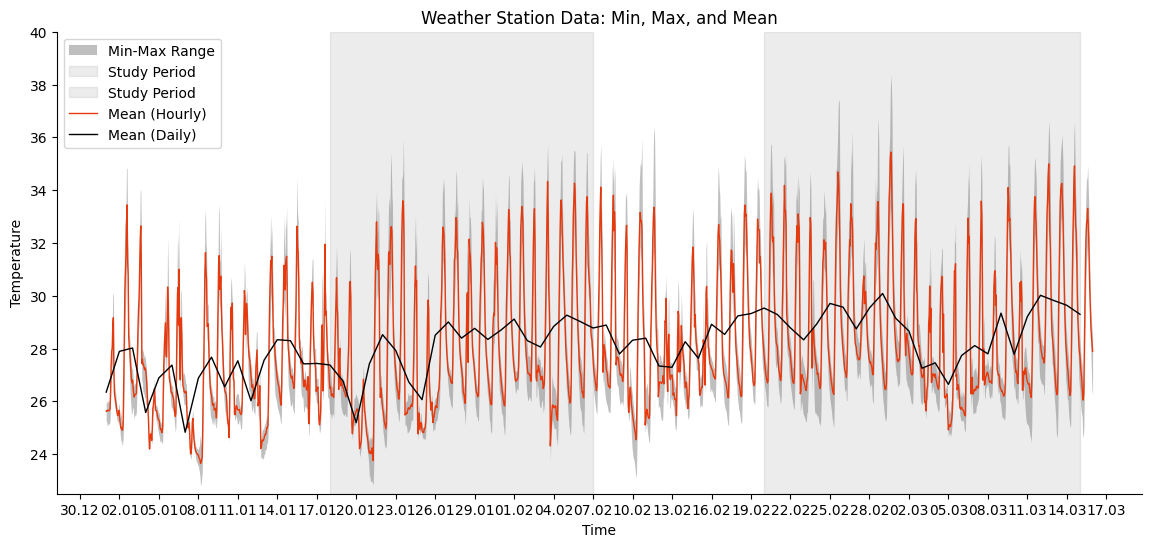

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_RelHumidity.png


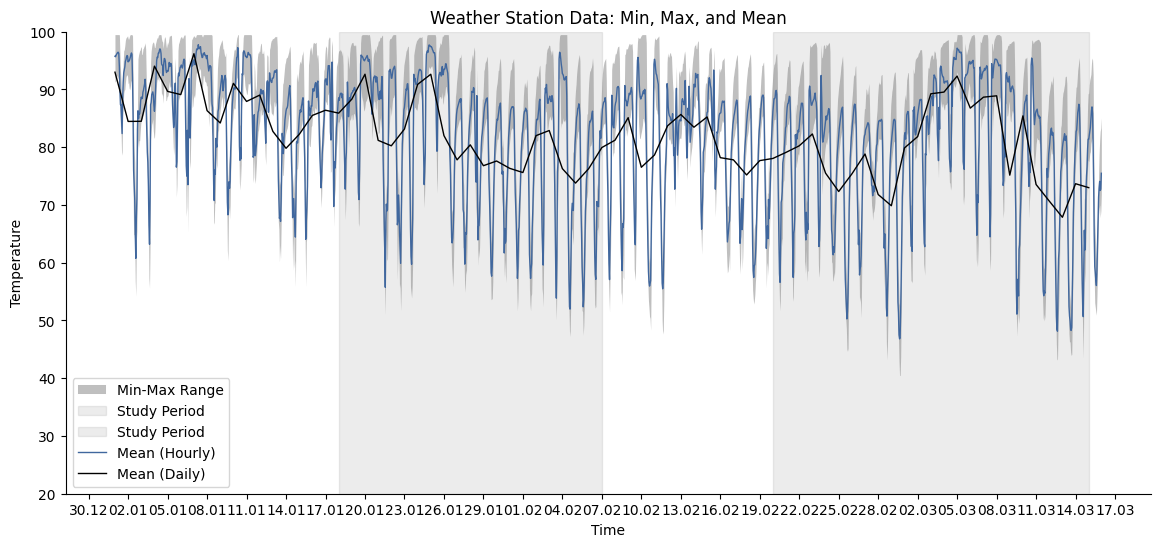

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Linechart_SolRadiation.png


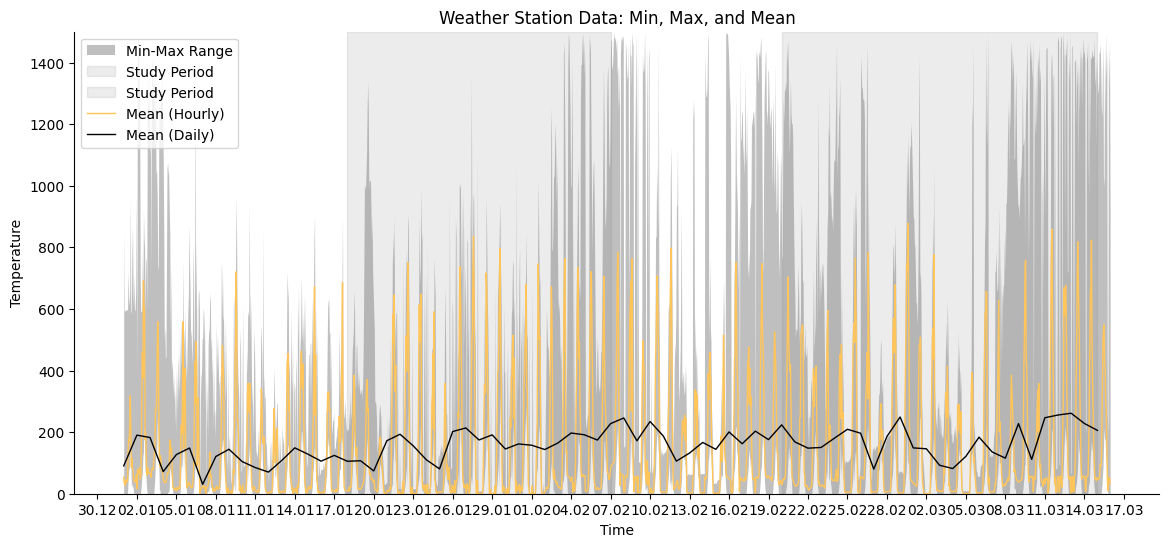

In [9]:
plot_weather_station_data(WS_Temp_df, filepath_dir, "Linechart_AirTemperature.png", color_vulcanfire, 22.5, 40)
plot_weather_station_data(WS_relH_df, filepath_dir, "Linechart_RelHumidity.png", cBlue, 20, 100)
plot_weather_station_data(WS_Rad_df, filepath_dir, "Linechart_SolRadiation.png", cYellow, 0, 1500)

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.dates import DateFormatter, DayLocator

def plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum):
    # Resample data to 1-hour intervals and calculate mean
    start_date = '2024-01-01'
    end_date = '2024-03-15'
    df = WS_Temp_df.loc[start_date:end_date]
    
    df = df.resample('4H').mean()

    # Resample data by day to get daily mean
    daily_mean_values = WS_Temp_df.resample('D').mean().mean(axis=1)

    # Plotting the data
    plt.figure(figsize=(14, 6))

    # Plotting all values as points

    for col in df.columns:
        sns.scatterplot(data=df, x=df.index, y=df[col], color='blue', alpha=0.3, label='_nolegend_', s=15)

    plt.axvspan(pd.Timestamp('2024-01-18'), pd.Timestamp('2024-02-07'), color='black', alpha=0.5, label='Study Period', hatch='/')

    plt.axvspan(pd.Timestamp('2024-02-20'), pd.Timestamp('2024-03-15'), color='black', alpha=0.5, hatch='/')

    # Plotting the daily mean values as a black line
    sns.lineplot(x=daily_mean_values.index, y=daily_mean_values, color='black', label='Mean (Daily)', linewidth=2)

    # Setting y-axis limits
    plt.ylim(minimum, maximum)

    # Formatting the x-axis to show dates in DD.MM format
    plt.gca().xaxis.set_major_formatter(DateFormatter("%d.%m"))
    plt.gca().xaxis.set_major_locator(DayLocator(interval=3))

    # Removing the top and right spines
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.title('Weather Station Data: All Values and Mean')
    plt.xlabel('Time')
    plt.ylabel('Temperature')
    plt.legend()

    # Saving the plot
    if filepath_dir:
        filepath = os.path.join(filepath_dir, Name)
        directory = os.path.dirname(filepath)
        
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")

    plt.show()


Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\test.png


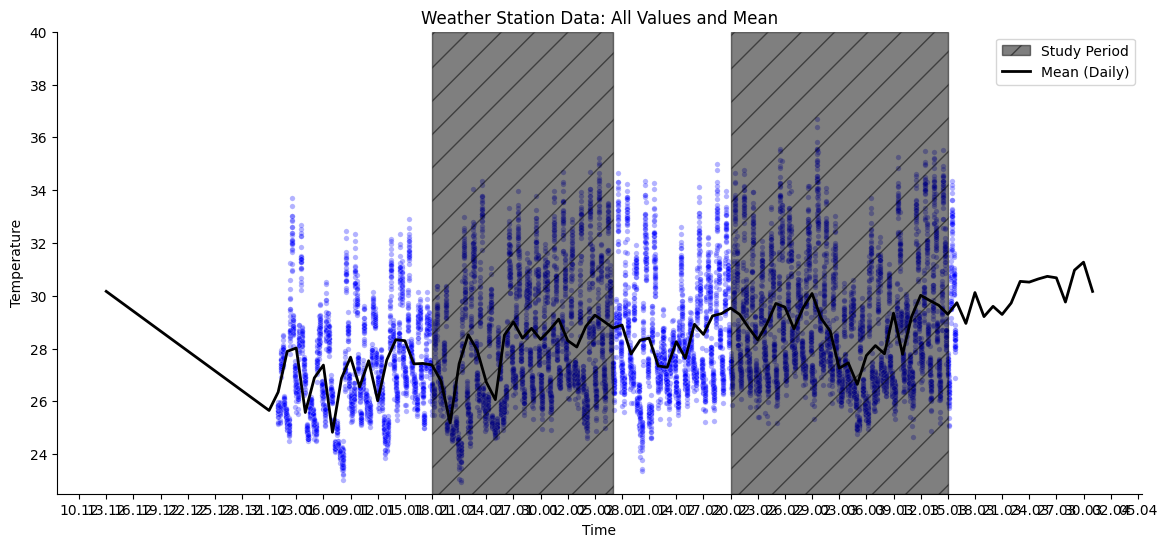

In [11]:
highlightColor = 'red'
minimum = 22.5
maximum = 40
Name = 'test.png'

plot_weather_station_data(WS_Temp_df, filepath_dir, Name, highlightColor, minimum, maximum)

C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1931919520.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1931919520.py:80: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\Boxchart_AirTemperaturewithTotalValues_Day.png


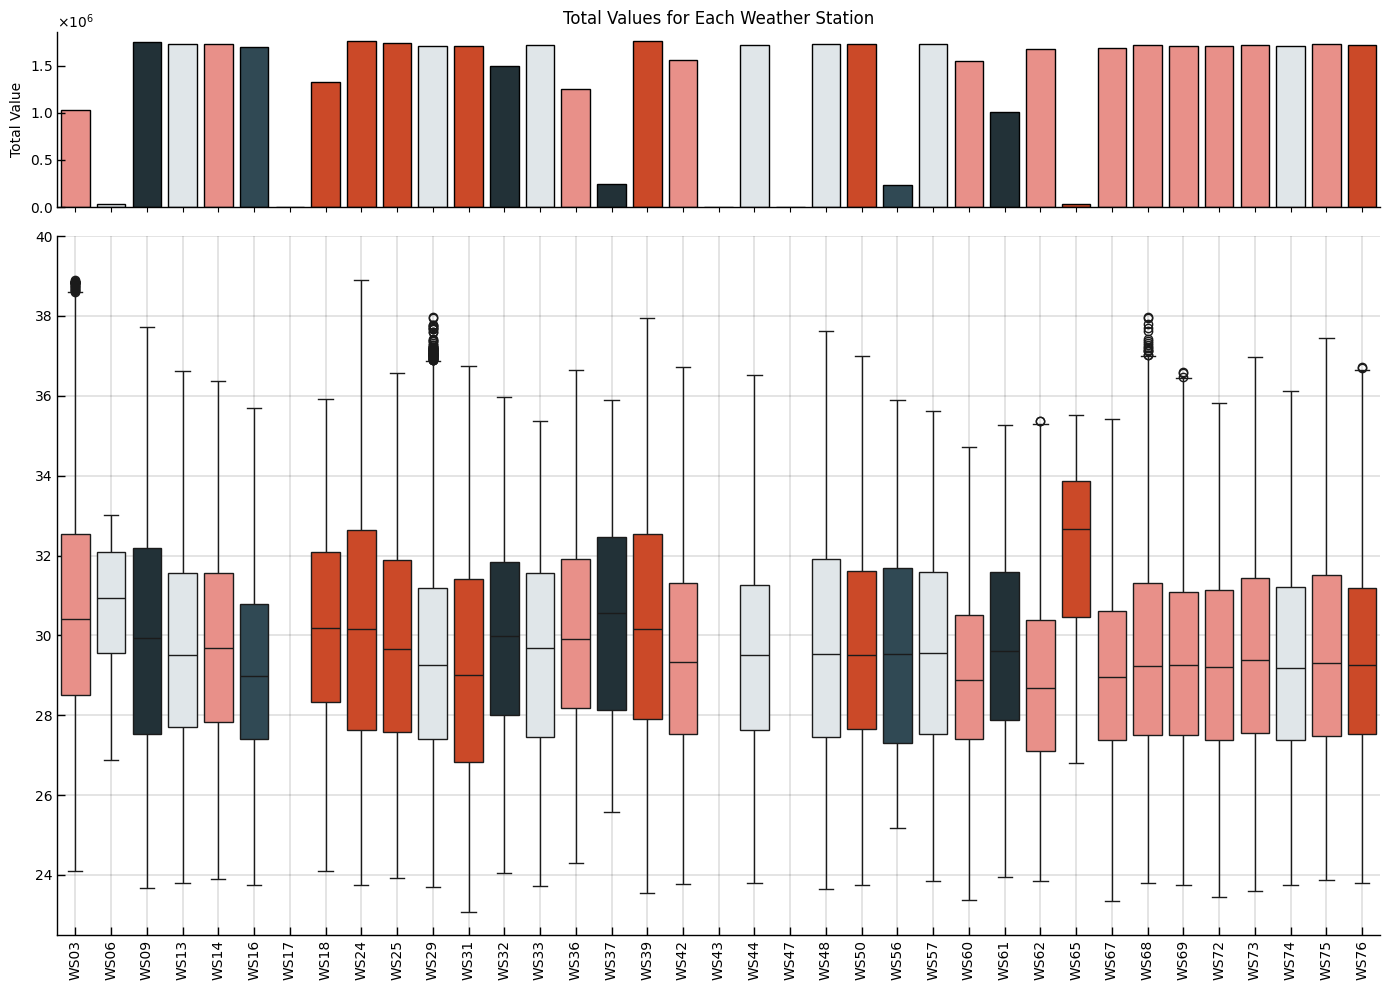

In [12]:
# -------------------------------------------------------------------------------------------
# Plot the boxplots
#
# -------------------------------------------------------------------------------------------

# Assume color_citylights, color_coralpink, color_vulcanfire, color_deepseablue, and color_elderberryblack are predefined color values.

# Create the cluster info DataFrame
# WS_Temp_filtered_df.index = pd.to_datetime(WS_Temp_filtered_df.index)

# Filter based on the hour
filtered_df = WS_Temp_filtered_df[(WS_Temp_filtered_df.index.hour > 7) & (WS_Temp_filtered_df.index.hour < 21)]

# Optionally rename columns
filtered_df.columns = [col.split('_')[0] for col in filtered_df.columns]

df = filtered_df
# Create a dictionary for the cluster values
cluster_dict = dict(zip(withCluster_WS_df['Shortname'], withCluster_WS_df['Cluster']))

# Predefined color map for clusters
predefined_colors = {0: color_citylights, 1: color_coralpink, 2: color_vulcanfire, 3: color_deepseablue, 4: color_elderberryblack}

# Generate a color palette with distinct colors for each unique cluster
unique_clusters = sorted(set(cluster_dict.values()))
palette = sns.color_palette("husl", len(unique_clusters))
color_map = {cluster: palette[i] for i, cluster in enumerate(unique_clusters)}

# Update the color map with predefined colors
color_map.update(predefined_colors)

# Map colors to the columns in the DataFrame based on the cluster
column_colors = [color_map[cluster_dict.get(col, 0)] for col in df.columns]

# Calculate total values
total_values = df.sum()

# Create subplots
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [1, 4]})

# Bar plot on the first axis
bar = sns.barplot(x=total_values.index, y=total_values.values, ax=ax1, palette=column_colors)

# Customize bar plot aesthetics
ax1.set_title('Total Values for Each Weather Station')
ax1.set_ylabel('Total Value')
ax1.set_facecolor('white')
ax1.set_xticklabels([])  # Remove x-tick labels
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['bottom'].set_color('black')
ax1.spines['left'].set_linewidth(1)
ax1.spines['left'].set_color('black')
ax1.tick_params(axis='y', direction='in', length=6, width=1, colors='black')

ax1.set_xlabel('')

# Add black outline to bars
for patch in ax1.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(1)  # Set black outline

ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax1.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Box plot on the second axis
box = sns.boxplot(data=df, ax=ax2, palette=column_colors)

# Apply colors to the boxplot elements and set transparency
for i, patch in enumerate(box.artists):
    patch.set_facecolor(column_colors[i])
    patch.set_edgecolor('black')
    patch.set_alpha(1)

# Customize box plot aesthetics
#ax2.set_title('Boxplots of Each Column')
ax2.set_ylim(22.5, 40)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_facecolor('white')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.spines['bottom'].set_color('black')
ax2.spines['left'].set_linewidth(1)
ax2.spines['left'].set_color('black')
fig.set_facecolor('white')
ax2.tick_params(axis='both', which='both', direction='in', length=6, width=1, colors='black')
ax2.grid(True, which='both', axis='both', color='black', linestyle='-', linewidth=0.15)

# Adjust layout
plt.tight_layout()

# Show the plot
filepath = os.path.join(filepath_dir, "Boxchart_AirTemperaturewithTotalValues_Day.png")
if filepath != "":
    directory = os.path.dirname(filepath)
        
    # Create directory if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
    print(f"Plot saved to {filepath}")

plt.show()



What do i need?

A Boxplot for each weather station, average, time of the day (night and day) and a linechart for the temperature path during the study
-- > this for each weatherstation as a layout plot

plot per average minute values, mazbe cluster the differnte stations based on environment

## Regression Kriging


In [13]:
#TODO!
#analyse the weather station data
#How to do the krigign, check the gps data, what are the time differences


#Get the participant Data local and filter out the relevenat dates and times by 5min increments? DONE
#Create a plot, how much time on average on runs between Locations points, this is the base fro the interpolation DONE
#Combine all weather data into one df DONE
#Take from the pool the relevant data and create the waetherdatafiles for the regression
#Analysie the temperatrue data in a linechart plot


# Directory Definitions
parent_dir: str = 'C:/Users/gottk/OneDrive/GITHUB/calma-esse-heat-stress-internal/Esse/data/krigging/'
dirWH: str = os.path.join(parent_dir, 'Weatherdata')
dirOut: str = r'Esse\report\krigging_output'

# File Definitions
griddf    = pd.read_csv(parent_dir + '5mGrid_features_original.csv').fillna(0)
wsdf      = kriging_ws_df.drop(columns=['Lon', 'Lat']) #pd.read_csv(parent_dir + 'WS_features.csv').fillna(0) #whz is this 43 and not 38


today = dt.datetime.now().strftime("%m%d%y-%H%M")
print(today)


#Load Files and make a feature selection
#Feature selection
terrain_features  = ['Ter_height']
sky_features      = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx']
bld_features      = ['Bld_percent', 'Bld_height']
veg_features      = ['Veg_height', 'Veg_percent']
distance_features = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad',  'distToPath', 'distToCourtTrack', 'distToCarpark']

features = distance_features + sky_features   + veg_features  + bld_features + terrain_features

display(griddf)
display(wsdf)
print(features)

080124-0715


Unnamed: 0        X        Y     id  distToTree  distToCarpark  \
0               0  22187.5  30692.5  77604    0.000000      63.307985   
1               1  22187.5  30687.5  77605    0.000000      68.014909   
2               2  22197.5  30722.5  78180   55.263466      31.693100   
3               3  22197.5  30717.5  78181   60.041791      36.400010   
4               4  21632.5  30382.5  45365   23.579758      65.397386   
...           ...      ...      ...    ...         ...            ...   
56175       56175  22427.5  30452.5  91620   54.094083     111.624158   
56176       56176  22427.5  30447.5  91621   50.504236     114.951070   
56177       56177  22427.5  30442.5  91622   47.171875     118.395712   
56178       56178  22427.5  30437.5  91623   44.155337     121.948106   
56179       56179  22437.5  30472.5  92198   65.838682     108.331651   

       distToCourtTrack  distToPath  distToRoad  distToWalkway  \
0            126.195950    7.390848   25.440924      23.503916   
1            124.831602   12.087238   21.686119      19.737900   
2            146.781762    5.106590   54.906503      53.416358   
3            144.576612    4.768805   51.022771      49.227171   
4            287.481258  171.065282    3.948153      53.468093   
...                 ...         ...         ...            ...   
56175        243.602350  116.723498    2.290531       0.790519   
56176        240.452998  119.067464    6.069861       4.569858   
56177        237.367190  121.571983    9.849192       8.349197   
56178        234.347439  124.227344   13.628522      12.128536   
56179        264.195774  116.571714    2.857030       1.695753   

       distToBuilding  Sun_h  Bld_SkyEx  Veg_SkyEx  Veg_height  Veg_percent  \
0           11.635957      9  63.078176  66.049332   49.424421     0.000000   
1           16.420043      9  64.015580  50.917968   49.628777     0.000000   
2            0.000000      0   0.000000  75.245290   43.347381     5.203222   
3            0.000000      0   0.000000  75.892621   43.828036     0.000000   
4            0.000000      0   0.000000  62.211868   15.752680     0.000000   
...               ...    ...        ...        ...         ...          ...   
56175       29.217055     10  75.183959   0.000000   45.294563     0.000000   
56176       26.109542     10  74.521210   0.000000   44.373172     0.000000   
56177       23.643713     10  75.183959   0.000000   43.497971     0.000000   
56178       22.053167     10  77.247454   0.000000   42.621719     0.000000   
56179       49.863231     11  75.286562  55.989593   48.414704     0.000000   

       Bld_percent  Bld_height  Ter_height  
0         0.000000    0.000000   49.424421  
1        85.062123    0.000000   49.628777  
2         0.000000   63.791724   43.347381  
3         0.000000   63.791724   43.828036  
4         0.000000   36.428059   15.752680  
...            ...         ...         ...  
56175    50.071585    0.000000   45.294563  
56176    17.031179    0.000000   44.373172  
56177    26.052403    0.000000   43.497971  
56178    53.265738    0.000000   42.621719  
56179     0.000000    0.000000   48.414704  

[56180 rows x 19 columns]

X             Y Shortname  distToBuilding  distToTree  \
0   21090.276586  31446.608220      WS76       19.128200    4.284713   
1   21018.301427  31316.750821      WS60        1.537213   10.722323   
2   21066.835035  31298.582162      WS62        4.424256   49.587268   
3   21039.589703  31247.486168      WS03        0.688038   52.153701   
4   21036.026652  31177.437049      WS75        2.293562   27.569884   
5   20997.720468  31187.013787      WS73        0.000000   19.555463   
6   21256.096493  31289.079173      WS61        4.020472   12.198471   
7   21315.797958  31495.288895      WS29       25.335737    7.523124   
8   21464.100803  31340.679569      WS25       48.163666    4.675180   
9   21255.134122  31069.355797      WS11        2.024010   16.832984   
10  21224.081973  30990.339713      WS06       21.321996    8.097994   
11  21131.705693  30803.757850      WS72        0.000000   13.937287   
12  21109.823138  30693.891156      WS48       17.398824   10.738127   
13  20960.702079  30623.359099      WS42        6.057834    4.519481   
14  21294.580617  30807.104351      WS33       33.428024    6.612097   
15  21432.486790  30548.112574      WS67        0.000000   29.024154   
16  21455.768419  30524.990823      WS32        6.266723    3.807541   
17  21475.886980  30879.869442      WS31       21.474524    7.056244   
18  21626.528010  30753.766383      WS09        2.217617   16.076289   
19  21961.733981  30589.699044      WS47       17.354936    7.918616   
20  22166.829489  30425.380453      WS36        2.767051   16.032380   
21  22160.607367  30380.332373      WS13       14.224248   23.193680   
22  22176.909473  30278.569970      WS65       27.656625   33.529409   
23  22358.940967  30434.322065      WS14        0.358568   14.227066   
24  21843.421234  31151.167744      WS18       38.371937   18.518209   
25  21789.133769  31167.832574      WS39       27.958721   15.963262   
26  22047.530518  31211.758394      WS24       13.504570   19.817695   
27  22149.806158  31167.526292      WS50       27.174168   11.156864   
28  21969.443913  30990.510750      WS37       16.676764    4.520793   
29  22051.830921  30900.965451      WS68        0.613446   10.018940   
30  22082.916778  31006.088346      WS17        5.203180    4.456662   
31  22245.700611  30916.088072      WS69        0.000000   14.776669   
32  22192.289275  30786.860294      WS16       15.393580    4.304746   
33  21843.814105  30795.205030      WS56       47.976820    7.503422   
34  21305.389115  32295.232293      WS77       11.709466    8.111947   
35  21319.105336  32047.356177      WS43       11.709466    8.111947   
36  21308.353072  31981.708108      WS74       11.709466    8.111947   
37  21294.207918  31978.114762      WS45       11.709466    8.111947   
38  21189.602346  31842.452925      WS57       10.464857   12.347953   
39  21381.476569  31739.691061      WS44       21.304567   13.529543   

    distToWalkway  distToRoad  distToPath  distToCourtTrack  distToCarpark  \
0        2.882867    3.259025   24.274148        124.320885       0.993472   
1       34.411467    8.975619   42.236555        237.027608      29.442126   
2       82.913897   24.602551   93.384464        209.561481      66.425462   
3       63.223702    1.204938   90.606105        266.488215      59.082799   
4      105.344386    2.703513   22.051692        324.218813      56.721544   
5       77.372840   13.887841   20.735570        338.544928      25.301949   
6       58.636647   58.990987   46.913593        130.108353       0.746239   
7        8.136926    2.765610   16.952240         66.202427      14.443943   
8        7.799220    0.614339   24.578732        184.702374      21.222501   
9        1.187438    2.769622   11.446123        348.361701      12.393354   
10       2.636932    0.536921   13.035982        426.373669      69.967004   
11      70.128929   56.406037   18.836690        260.163317      75.193177   
12      25.490585   27.001010   34.217846       

['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height']


In [14]:
display(wsdf.sort_values(['Shortname']))

X             Y Shortname  distToBuilding  distToTree  \
3   21039.589703  31247.486168      WS03        0.688038   52.153701   
10  21224.081973  30990.339713      WS06       21.321996    8.097994   
18  21626.528010  30753.766383      WS09        2.217617   16.076289   
9   21255.134122  31069.355797      WS11        2.024010   16.832984   
21  22160.607367  30380.332373      WS13       14.224248   23.193680   
23  22358.940967  30434.322065      WS14        0.358568   14.227066   
32  22192.289275  30786.860294      WS16       15.393580    4.304746   
30  22082.916778  31006.088346      WS17        5.203180    4.456662   
24  21843.421234  31151.167744      WS18       38.371937   18.518209   
26  22047.530518  31211.758394      WS24       13.504570   19.817695   
8   21464.100803  31340.679569      WS25       48.163666    4.675180   
7   21315.797958  31495.288895      WS29       25.335737    7.523124   
17  21475.886980  30879.869442      WS31       21.474524    7.056244   
16  21455.768419  30524.990823      WS32        6.266723    3.807541   
14  21294.580617  30807.104351      WS33       33.428024    6.612097   
20  22166.829489  30425.380453      WS36        2.767051   16.032380   
28  21969.443913  30990.510750      WS37       16.676764    4.520793   
25  21789.133769  31167.832574      WS39       27.958721   15.963262   
13  20960.702079  30623.359099      WS42        6.057834    4.519481   
35  21319.105336  32047.356177      WS43       11.709466    8.111947   
39  21381.476569  31739.691061      WS44       21.304567   13.529543   
37  21294.207918  31978.114762      WS45       11.709466    8.111947   
19  21961.733981  30589.699044      WS47       17.354936    7.918616   
12  21109.823138  30693.891156      WS48       17.398824   10.738127   
27  22149.806158  31167.526292      WS50       27.174168   11.156864   
33  21843.814105  30795.205030      WS56       47.976820    7.503422   
38  21189.602346  31842.452925      WS57       10.464857   12.347953   
1   21018.301427  31316.750821      WS60        1.537213   10.722323   
6   21256.096493  31289.079173      WS61        4.020472   12.198471   
2   21066.835035  31298.582162      WS62        4.424256   49.587268   
22  22176.909473  30278.569970      WS65       27.656625   33.529409   
15  21432.486790  30548.112574      WS67        0.000000   29.024154   
29  22051.830921  30900.965451      WS68        0.613446   10.018940   
31  22245.700611  30916.088072      WS69        0.000000   14.776669   
11  21131.705693  30803.757850      WS72        0.000000   13.937287   
5   20997.720468  31187.013787      WS73        0.000000   19.555463   
36  21308.353072  31981.708108      WS74       11.709466    8.111947   
4   21036.026652  31177.437049      WS75        2.293562   27.569884   
0   21090.276586  31446.608220      WS76       19.128200    4.284713   
34  21305.389115  32295.232293      WS77       11.709466    8.111947   

    distToWalkway  distToRoad  distToPath  distToCourtTrack  distToCarpark  \
3       63.223702    1.204938   90.606105        266.488215      59.082799   
10       2.636932    0.536921   13.035982        426.373669      69.967004   
18      36.501375   30.934776   45.937303        359.453853      75.937174   
9        1.187438    2.769622   11.446123        348.361701      12.393354   
21       9.367620    0.453165   26.113179         84.537642     144.646830   
23      11.968159    0.336127   79.095522        181.428764      70.104354   
32     112.908690   21.388652   60.729874        182.139999       0.000000   
30      44.943620    2.803674   62.505130        223.333491       8.610973   
24      41.901288    5.027914   18.681339          1.796393     153.577672   
26     127.611170  131.250460  102.532642        117.399845      45.400862   
8        7.799220    0.614339   24.578732        184.702374      21.222501   
7        8.136926    2.765610   16.952240         66.202427      14.443943   
17       1.668720    1.651445   37.838521       

### Get the Weather Data to interpolate


In [15]:
### Specify temperature measure to use
import math
from datetime import timedelta

# GET COZIE DATA
participant_data_local_df = pd.read_csv(r'C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\data\processed\participant_data_local_df.csv', parse_dates=['index_time'])

participant_data_local_df['index_time'] = pd.to_datetime(participant_data_local_df['index_time'], format='mixed')
participant_data_local_df['index_time'] = participant_data_local_df['index_time'].dt.tz_convert('Asia/Singapore')
# print(participant_data_local_df['index_time'].dtype) 
# display(participant_data_local_df['index_time']) 

participant_data_local_df = participant_data_local_df[
    participant_data_local_df['c_total_valid_data'] & 
    participant_data_local_df['c_longitude'].notnull()
]

df = participant_data_local_df[['index_time', 'id_participant','c_run_number', 'c_longitude', 'c_latitude']]

unique_run_numbers = df.groupby('id_participant')['c_run_number'].unique()
print(unique_run_numbers)

# Select data for id_participant = 'esse00' and c_run_number = 1
specific_data = df[
    (df['id_participant'] == 'esse02') & 
    (df['c_run_number'] != -1)
]

specific_data['index_time'] = specific_data['index_time'].dt.ceil('T')
index_time_list = specific_data['index_time'].tolist()

WS_Temp_df = LoadWeatherStationDataIntoDf('AirTemp Ave (C)', dirs)
WS_Temp_df.index = pd.to_datetime(WS_Temp_df.index).tz_localize('UTC').tz_convert('Asia/Singapore')
WS_Temp_df.columns = [col.split('_')[0] for col in WS_Temp_df.columns]
WS_df = WS_Temp_df.transpose()
reference_time_list = WS_df.columns

columns_to_keep = []

for index_time in index_time_list:
    closest_time = None
    min_diff = timedelta(minutes=3)

    for ref_time in reference_time_list:
        time_diff = abs(index_time - ref_time)
        if time_diff <= min_diff:
            closest_time = ref_time

    if closest_time is not None:
        columns_to_keep.append(closest_time)

# Remove duplicates and convert to list
columns_to_keep = list(set(columns_to_keep))

print("Columns to keep:", columns_to_keep)

location_df = specific_data[['index_time', 'c_longitude', 'c_latitude']]
location_df.set_index('index_time', inplace=True)
display(location_df)

# Usage example
selected_columns_df = WS_df[columns_to_keep].reset_index()
selected_columns_df.set_index('index', inplace=True)
selected_columns_df.index.name = 'Shortname'

measure_df = kriging_ws_df[['Lat', 'Lon', 'Shortname']]
display(measure_df.describe())

# Merge based on the 'Shortname' column
df = pd.merge(measure_df, selected_columns_df, on='Shortname', how='outer')
df = df.drop('Shortname', axis=1)
df = df.reset_index(inplace=False)
df.columns = df.columns.astype(str)
# Fill NaN values with median of each column
# Skip non-numeric columns (like index or location columns)
# numeric_columns = df.select_dtypes(include=[np.number]).columns
# Calculate median for each numeric column
#medians = df.median()
# Fill NaN values with the median of each column
#df[numeric_columns] = df[numeric_columns].fillna(medians)
display(df.describe())

pprint(df.columns)



C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1467920188.py:6: DtypeWarning:

Columns (5,6,7,9,11,13,17,18,19,21,25,26,46,47,49,50,79,80,82,83,97) have mixed types. Specify dtype option on import or set low_memory=False.



id_participant
esse00    [4.0, -1.0, 5.0, 6.0, 8.0, 11.0, 13.0, 15.0, 1...
esse01    [2.0, -1.0, 7.0, 11.0, 16.0, 18.0, 19.0, 21.0,...
esse02    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 10.0...
esse03    [-1.0, 0.0, 1.0, 4.0, 8.0, 9.0, 12.0, 13.0, 14...
esse04    [-1.0, 9.0, 16.0, 18.0, 19.0, 21.0, 25.0, 26.0...
esse05    [-1.0, 1.0, 2.0, 3.0, 4.0, 6.0, 7.0, 8.0, 10.0...
esse06    [-1.0, 1.0, 2.0, 4.0, 5.0, 6.0, 7.0, 9.0, 10.0...
esse07    [0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 9.0, 10.0, 17....
esse08    [nan, 0.0, -1.0, 1.0, 2.0, 3.0, 5.0, 7.0, 8.0,...
esse09    [-1.0, 0.0, 1.0, 2.0, 4.0, 5.0, 8.0, 9.0, 16.0...
esse10    [-1.0, 1.0, 2.0, 3.0, 7.0, 9.0, 20.0, 21.0, 24...
esse11    [-1.0, 5.0, 13.0, 39.0, 55.0, 56.0, 62.0, 69.0...
esse13    [-1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 11.0...
esse14    [1.0, -1.0, 7.0, 14.0, 20.0, 22.0, 42.0, 44.0,...
Name: c_run_number, dtype: object


C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\1467920188.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\gottk\AppData\Local\Temp\ipykernel_15440\376362726.py:27: FutureWarning:

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.



Columns to keep: [Timestamp('2024-03-19 19:07:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-22 22:23:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-22 13:46:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-20 11:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-13 14:11:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-04 13:55:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-21 20:12:00+0800', tz='Asia/Singapore'), Timestamp('2024-02-28 13:38:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-06 19:57:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-07 13:04:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-06 18:02:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-05 12:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-11 16:30:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-07 18:17:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-19 07:17:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-08 19:41:00+0800', tz='Asia/Singapore'), Timestamp('2024-03-05 

c_longitude  c_latitude
index_time                                        
2024-02-20 10:26:00+08:00   103.770914    1.297225
2024-02-20 10:51:00+08:00   103.771494    1.298664
2024-02-20 10:51:00+08:00   103.771699    1.299204
2024-02-20 11:01:00+08:00   103.773358    1.300284
2024-02-20 11:38:00+08:00   103.780804    1.297369
...                                ...         ...
2024-03-22 19:26:00+08:00   103.774246    1.292458
2024-03-22 19:26:00+08:00   103.774246    1.292458
2024-03-22 19:35:00+08:00   103.773939    1.291838
2024-03-22 22:20:00+08:00   103.773130    1.300279
2024-03-22 22:31:00+08:00   103.773368    1.300287

[121 rows x 2 columns]

Lat         Lon
count  40.000000   40.000000
mean    1.297436  103.775383
std     0.004432    0.003947
min     1.290103  103.770067
25%     1.294625  103.772357
50%     1.296968  103.774077
75%     1.299368  103.779307
max     1.308340  103.782631

index        Lat         Lon  2024-03-19 19:07:00+08:00  \
count  40.000000  40.000000   40.000000                  34.000000   
mean   19.500000   1.297436  103.775383                  32.379118   
std    11.690452   0.004432    0.003947                   1.040622   
min     0.000000   1.290103  103.770067                  30.870000   
25%     9.750000   1.294625  103.772357                  31.650000   
50%    19.500000   1.296968  103.774077                  32.220000   
75%    29.250000   1.299368  103.779307                  32.807500   
max    39.000000   1.308340  103.782631                  35.180000   

       2024-03-22 22:23:00+08:00  2024-02-22 13:46:00+08:00  \
count                  33.000000                  30.000000   
mean                   33.704848                  26.698333   
std                     0.749263                   0.320378   
min                    32.290000                  25.770000   
25%                    33.250000                  26.510000   
50%                    33.690000                  26.745000   
75%                    34.020000                  26.935000   
max                    35.250000                  27.230000   

       2024-02-20 11:41:00+08:00  2024-03-13 14:11:00+08:00  \
count                  30.000000                  31.000000   
mean                   27.031667                  26.298065   
std                     0.259935                   0.447813   
min                    26.360000                  24.620000   
25%                    26.852500                  26.075000   
50%                    27.085000                  26.430000   
75%                    27.190000                  26.575000   
max                    27.470000                  26.930000   

       2024-03-04 13:55:00+08:00  2024-03-21 20:12:00+08:00  ...  \
count                  30.000000                  34.000000  ...   
mean                   26.452667                  32.817941  ...   
std                     0.312001                   0.794057  ...   
min                    25.600000                  31.320000  ...   
25%                    26.265000                  32.300000  ...   
50%                    26.580000                  32.825000  ...   
75%                    26.635000                  33.277500  ...   
max                    26.940000                  34.650000  ...   

       2024-03-22 19:29:00+08:00  2024-03-07 14:05:00+08:00  \
count                  33.000000                  32.000000   
mean                   32.329697                  26.509687   
std                     0.893317                   0.229902   
min                    30.520000                  26.030000   
25%                    31.820000                  26.377500   
50%                    32.180000                  26.520000   
75%                    32.910000                  26.697500   
max                    34.470000                  26.860000   

       2024-03-06 18:16:00+08:00  2024-02-29 11:17:00+08:00  \
count                  32.000000                  30.000000   
mean                   30.708125                  26.721667   
std                     1.258413                   0.355383   
min                    28.790000                  25.610000   
25%                    29.612500                  26.507500   
50%                    30.680000                  26.815000   
75%                    31.780000                  26.957500   
max                    33.330000                  27.460000   

       2024-03-21 14:10:00+08:00  2024-03-13 17:28:00+08:00  \
count                  34.000000                  31.000000   
mean                   27.302941                  29.639355   
std                     0.353712                   1.087075   
min                    25.970000                  28.160000   
25%                    27.165000                  28.760000   
50%                    27.350000                  29.420000   
75%                    27.560000                  30.1

Index(['index', 'Lat', 'Lon', '2024-03-19 19:07:00+08:00',
       '2024-03-22 22:23:00+08:00', '2024-02-22 13:46:00+08:00',
       '2024-02-20 11:41:00+08:00', '2024-03-13 14:11:00+08:00',
       '2024-03-04 13:55:00+08:00', '2024-03-21 20:12:00+08:00',
       ...
       '2024-03-22 19:29:00+08:00', '2024-03-07 14:05:00+08:00',
       '2024-03-06 18:16:00+08:00', '2024-02-29 11:17:00+08:00',
       '2024-03-21 14:10:00+08:00', '2024-03-13 17:28:00+08:00',
       '2024-03-05 14:56:00+08:00', '2024-02-28 14:06:00+08:00',
       '2024-02-29 11:16:00+08:00', '2024-03-06 20:06:00+08:00'],
      dtype='object', length=111)


In [16]:
times = [col for col in df.columns if col not in ['index', 'Lat', 'Lon']]
print(len(times))
pprint(times)

108
['2024-03-19 19:07:00+08:00',
 '2024-03-22 22:23:00+08:00',
 '2024-02-22 13:46:00+08:00',
 '2024-02-20 11:41:00+08:00',
 '2024-03-13 14:11:00+08:00',
 '2024-03-04 13:55:00+08:00',
 '2024-03-21 20:12:00+08:00',
 '2024-02-28 13:38:00+08:00',
 '2024-03-06 19:57:00+08:00',
 '2024-03-07 13:04:00+08:00',
 '2024-03-06 18:02:00+08:00',
 '2024-03-05 12:41:00+08:00',
 '2024-03-11 16:30:00+08:00',
 '2024-03-07 18:17:00+08:00',
 '2024-03-19 07:17:00+08:00',
 '2024-03-08 19:41:00+08:00',
 '2024-03-05 14:49:00+08:00',
 '2024-03-05 12:32:00+08:00',
 '2024-03-22 07:28:00+08:00',
 '2024-03-06 13:17:00+08:00',
 '2024-02-22 17:29:00+08:00',
 '2024-03-13 14:01:00+08:00',
 '2024-02-20 21:50:00+08:00',
 '2024-03-21 18:22:00+08:00',
 '2024-03-04 16:06:00+08:00',
 '2024-03-05 20:13:00+08:00',
 '2024-03-21 18:37:00+08:00',
 '2024-03-22 22:34:00+08:00',
 '2024-03-06 19:58:00+08:00',
 '2024-03-07 13:20:00+08:00',
 '2024-03-04 12:00:00+08:00',
 '2024-03-21 20:27:00+08:00',
 '2024-02-20 10:54:00+08:00',
 '2024

In [17]:

from scipy.spatial import cKDTree
from pyproj import Transformer

# Define the transformer from UTM to WGS84
utm_to_wgs84 = Transformer.from_crs("epsg:32633", "epsg:4326")  # Example for UTM zone 33N

def convert_to_lon_lat(x, y):
    lon, lat = utm_to_wgs84.transform(x, y)
    return lon, lat

# Convert UTM to longitude and latitude for griddf
griddf[['Long', 'Lat']] = griddf.apply(lambda row: convert_to_lon_lat(row['X'], row['Y']), axis=1, result_type='expand')

# Extract relevant columns from specific_data and set index
location_df = specific_data[['index_time', 'c_longitude', 'c_latitude']]
location_df.set_index('index_time', inplace=True)

# Extract longitude and latitude from griddf
grid_points = griddf[['Long', 'Lat']].values

# Create a KDTree for efficient distance calculation
tree = cKDTree(grid_points)

# Function to find the 10 closest grid points and return their IDs
def find_closest_grid_points(lon, lat, k=5):
    distances, indices = tree.query([lon, lat], k=k)
    return griddf.iloc[indices]['id'].tolist()

# Apply the function to each row in location_df
closest_points = location_df.apply(lambda row: find_closest_grid_points(row['c_longitude'], row['c_latitude']), axis=1)

# Display the result
display(closest_points)


index_time
2024-02-20 10:26:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-02-20 10:51:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-02-20 10:51:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-02-20 11:01:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-02-20 11:38:00+08:00    [21536, 21827, 22118, 22409, 22700]
                                            ...                 
2024-03-22 19:26:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-03-22 19:26:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-03-22 19:35:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-03-22 22:20:00+08:00    [21536, 21827, 22118, 22409, 22700]
2024-03-22 22:31:00+08:00    [21536, 21827, 22118, 22409, 22700]
Length: 121, dtype: object

### Clustering

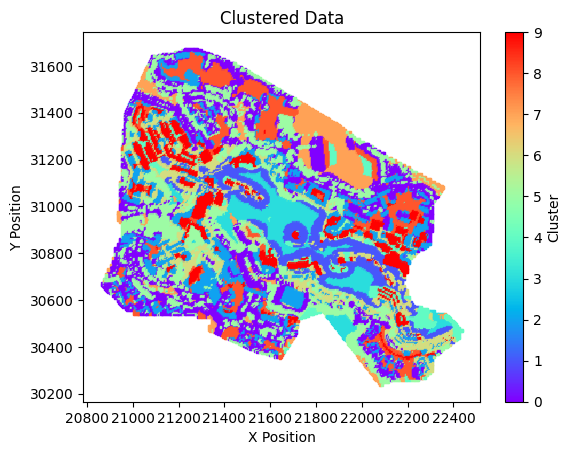

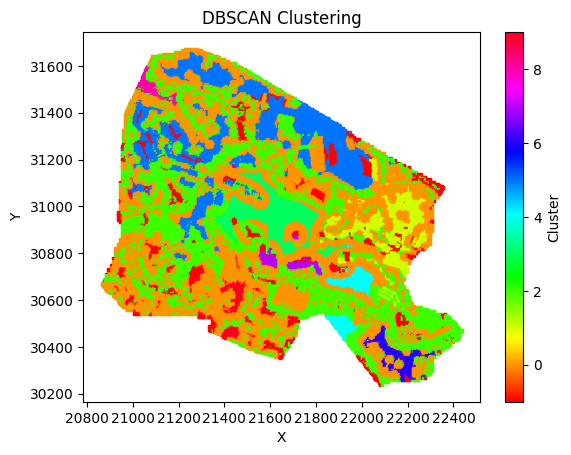

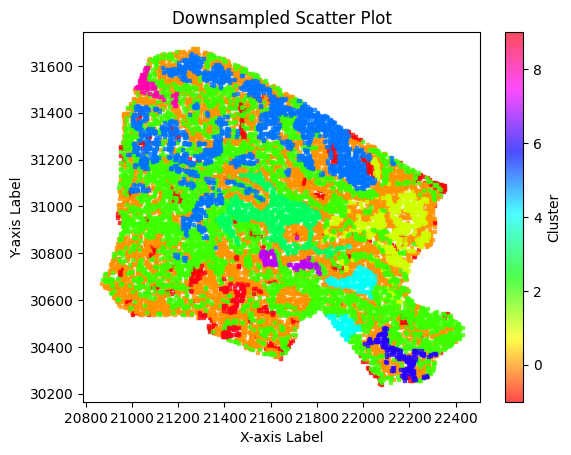

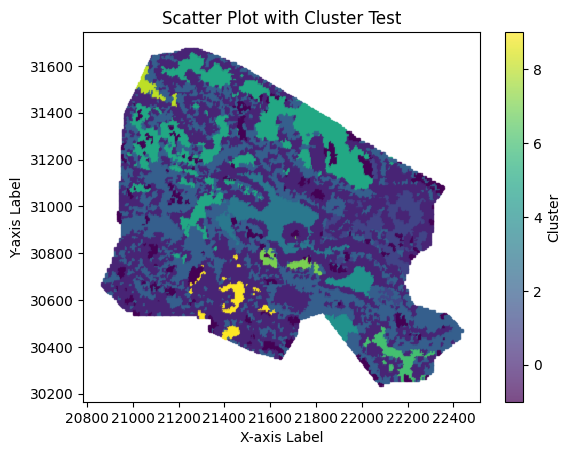

['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack', 'distToCarpark', 'Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height', 'cluster']


In [18]:
metadatadf = griddf.copy()

# Quantization function
def quantize_column(column, step_size):
    return round(column / step_size) * step_size

# Number of steps for quantization
num_steps = 3

feature_list = ['Bld_percent', 'distToBuilding', 'Bld_height', 'Veg_height', 'distToTree']


# Determine step sizes for each column and apply quantization
for col in feature_list:
    step_size = metadatadf[col].max() / num_steps
    metadatadf[f'quantized_{col}'] = metadatadf[col].apply(quantize_column, args=(step_size,))

# Standard scaling
scaler = StandardScaler()
metadatadf[feature_list] = scaler.fit_transform(metadatadf[feature_list])

# KMeans clustering
n_clusters = 10
metadatadf['cluster'] = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0).fit_predict(metadatadf[feature_list])

# Plot the clustered data
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='rainbow', s=1, marker='s')
plt.title('Clustered Data')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Cluster')
plt.show()
#-------------------------------------------------------------------------------------------------
# DBSCAN clustering
X = metadatadf[['cluster', 'X', 'Y']] #features for DBclustering
X_scaled = StandardScaler().fit_transform(X)

eps = 0.35
min_samples = 250
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
metadatadf['cluster'] = dbscan.fit_predict(X_scaled)

# Visualize the DBSCAN clustering
plt.scatter(metadatadf['X'], metadatadf['Y'], c=metadatadf['cluster'], cmap='hsv', s=1, marker='s')
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

#-------------------------------------------------------------------------------------------------
#downsampling and upscaling again
# Group by the cluster column
metadata_df_grp = metadatadf.groupby('cluster')

# Define a function to sample a specific percentage from each group
def downsample_group(group):
    return group.sample(frac=0.25)  # You can adjust the fraction as needed

# Apply the downsampling function to each group
downsampled_df = metadata_df_grp.apply(downsample_group)

# Reset the index of the downsampled DataFrame
downsampled_df.reset_index(drop=True, inplace=True)

plt.scatter(downsampled_df['X'], downsampled_df['Y'], c=downsampled_df['cluster'], cmap='hsv', alpha=0.7,  s=5, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Downsampled Scatter Plot')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

# Fit Nearest Neighbors model on the downsampled data
nn_model = NearestNeighbors(n_neighbors=1).fit(downsampled_df[['X', 'Y']])

# Find the index of the nearest neighbor for each point in griddf
distances, indices = nn_model.kneighbors(griddf[['X', 'Y']])

# Map the cluster values from downsampled_df to griddf based on the nearest neighbors
griddf['cluster'] = downsampled_df.loc[indices.flatten()]['cluster'].values

plt.scatter(griddf['X'], griddf['Y'], c=griddf['cluster'], cmap='viridis', alpha=0.7,  s=1, marker='s')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Scatter Plot with Cluster Test')

# Add a colorbar to show the cluster information
colorbar = plt.colorbar()
colorbar.set_label('Cluster')

# Show the plot
plt.show()

#-------------------------------------------------------------------------------------------------
#Somehow smooth the data..



#-------------------------------------------------------------------------------------------------
#adjusting the considered features
quantized_cols = metadatadf.filter(like='quantized').columns
# griddf = metadatadf.drop(columns=quantized_cols) #.drop(columns=['cluster_x', 'cluster_y'])

features.append('cluster')

### get features for wsdf
# Calculating distances using sklearn's NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(griddf[['X', 'Y']])
distances, indices = nbrs.kneighbors(wsdf[['X', 'Y']])
# Add the index of the closest point in griddf to wsdf
wsdf['closest_index'] = indices.flatten()
# Retrieve specific columns from griddf based on closest_index and merge it with wsdf and only new selection features
merged_data = wsdf.join(griddf['cluster'], on='closest_index') #rsuffix='_griddf')
# Drop the redundant 'closest_index' column
wsdf = merged_data.drop(columns=['closest_index'])


# Print the updated list
print(features)

#display(griddf)


### Visualize Features

In [66]:
def plot_heatmaps(dataframe, feature_list, cmap_list, n_cols=3, filepath_dir: str = 'test', filename: str = 'example.png'):
    """
    Plot heatmaps for the specified features in the given DataFrame using the provided colormaps.

    Parameters:
    - dataframe: pd.DataFrame containing the data
    - feature_list: List of column names to plot as features
    - cmap_list: List of colormaps to use for each feature
    - n_cols: Number of columns in the subplot grid (default is 3)
    """
    # Ensure no duplicate entries by averaging duplicates
    dataframe = dataframe.groupby(['X', 'Y'], as_index=False).mean()

    # Define number of rows for the subplot grid
    n_rows = (len(feature_list) + n_cols - 1) // n_cols

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 4), constrained_layout=True)

    for i, (feature, cmap) in enumerate(zip(feature_list, cmap_list)):
        ax = axes[i // n_cols, i % n_cols]
        
        # Reshape data into a grid
        x_unique = np.sort(dataframe['X'].unique())
        y_unique = np.sort(dataframe['Y'].unique())
        X, Y = np.meshgrid(x_unique, y_unique)
        Z = dataframe.pivot(index='Y', columns='X', values=feature).values

        # Plot heatmap
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap=cmap)
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Heatmap of {feature}')
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(False)

    # Remove any unused subplots
    if len(feature_list) < n_rows * n_cols:
        for j in range(len(feature_list), n_rows * n_cols):
            fig.delaxes(axes.flatten()[j])

    filepath = os.path.join(filepath_dir, filename)
    if filepath != "":
        directory = os.path.dirname(filepath)
            
        # Create directory if it doesn't exist
        if not os.path.exists(directory):
            os.makedirs(directory)
            
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0.1)
        print(f"Plot saved to {filepath}")


    plt.savefig(filepath)

    plt.show()

Unnamed: 0        X        Y     id  distToTree  distToCarpark  \
0           0  22187.5  30692.5  77604    0.000000      63.307985   
1           1  22187.5  30687.5  77605    0.000000      68.014909   
2           2  22197.5  30722.5  78180   55.263466      31.693100   
3           3  22197.5  30717.5  78181   60.041791      36.400010   
4           4  21632.5  30382.5  45365   23.579758      65.397386   

   distToCourtTrack  distToPath  distToRoad  distToWalkway  ...  Bld_SkyEx  \
0        126.195950    7.390848   25.440924      23.503916  ...  63.078176   
1        124.831602   12.087238   21.686119      19.737900  ...  64.015580   
2        146.781762    5.106590   54.906503      53.416358  ...   0.000000   
3        144.576612    4.768805   51.022771      49.227171  ...   0.000000   
4        287.481258  171.065282    3.948153      53.468093  ...   0.000000   

   Veg_SkyEx  Veg_height  Veg_percent  Bld_percent  Bld_height  Ter_height  \
0  66.049332   49.424421     0.000000     0.000000    0.000000   49.424421   
1  50.917968   49.628777     0.000000    85.062123    0.000000   49.628777   
2  75.245290   43.347381     5.203222     0.000000   63.791724   43.347381   
3  75.892621   43.828036     0.000000     0.000000   63.791724   43.828036   
4  62.211868   15.752680     0.000000     0.000000   36.428059   15.752680   

       Long        Lat  cluster  
0  0.276901  10.710011        2  
1  0.276856  10.710011        0  
2  0.277172  10.710100        1  
3  0.277127  10.710100        1  
4  0.274103  10.705038        0  

[5 rows x 22 columns]

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\features_01


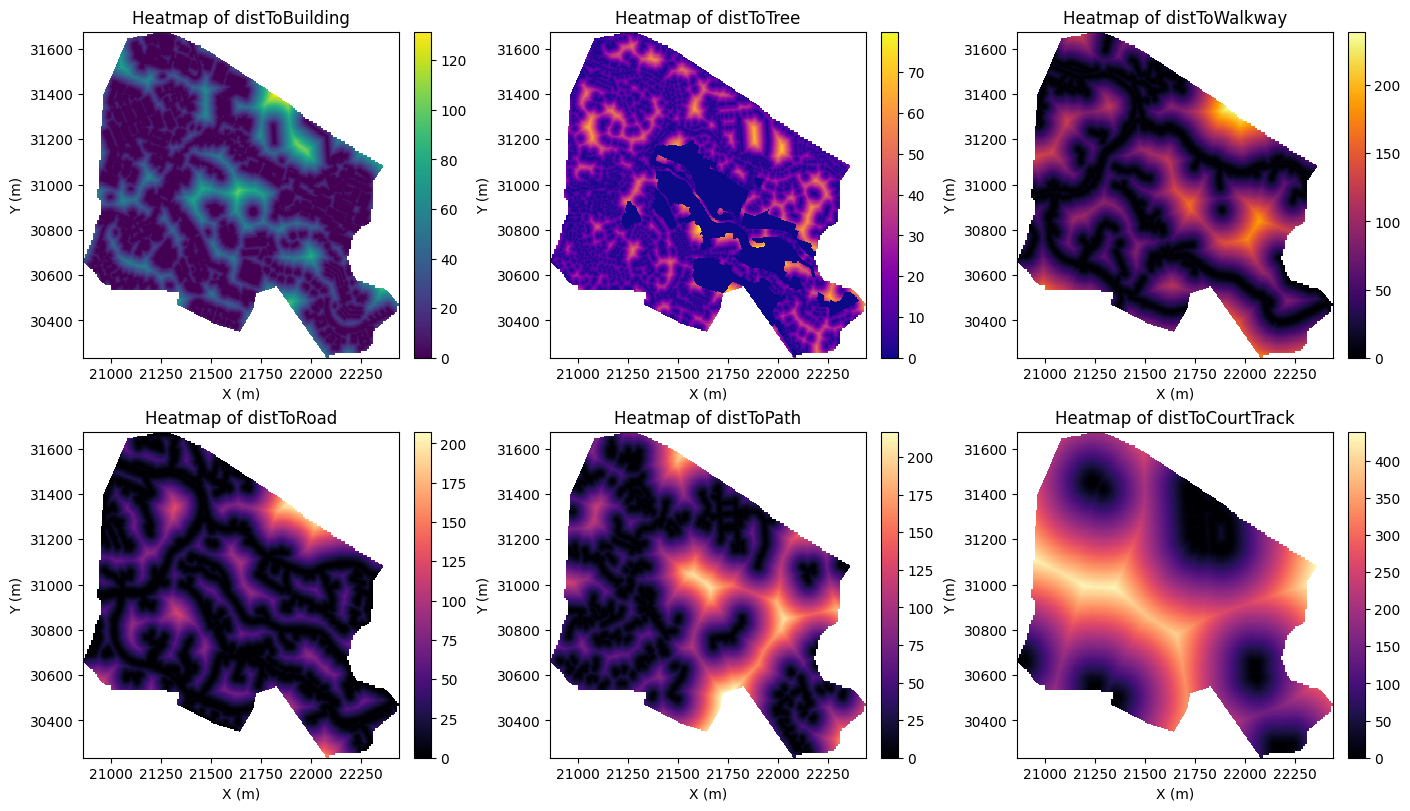

Plot saved to C:\Users\gottk\OneDrive\GITHUB\calma-esse-heat-stress-internal\Esse\report\_00-Krigging\features_02


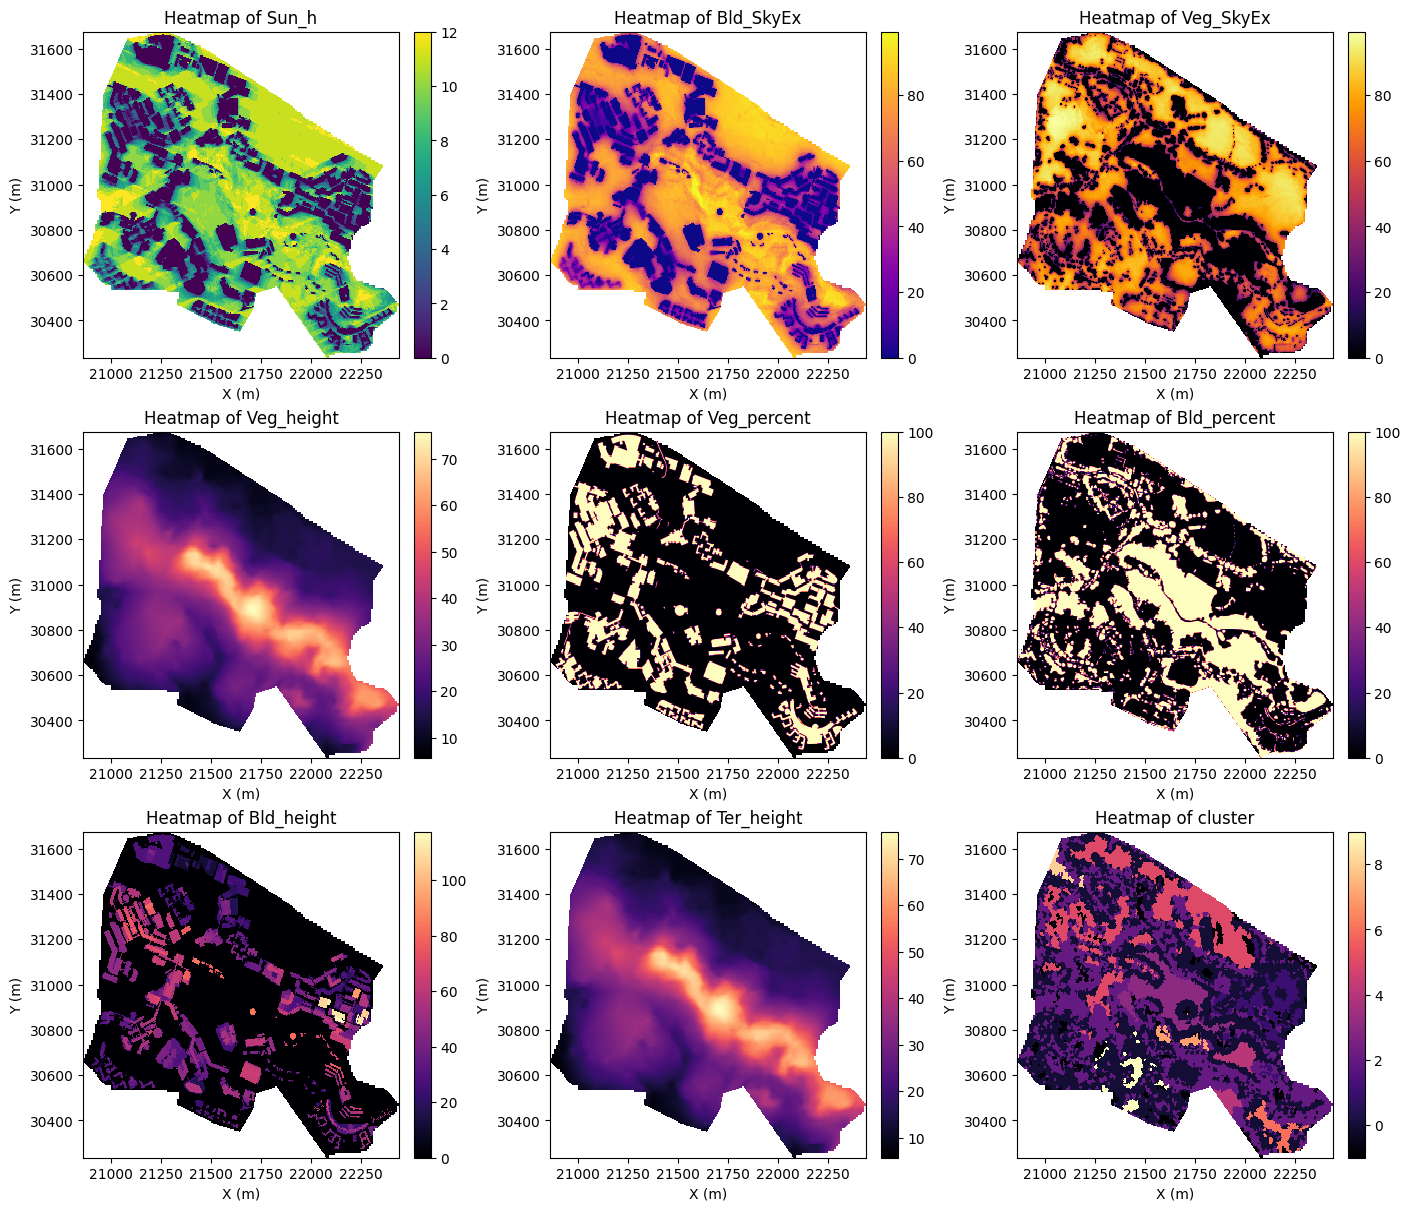

In [68]:
feature_df = griddf
display(feature_df.head(5))

feature_list = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad', 'distToPath', 'distToCourtTrack'] #'distToCarpark'
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3, filepath_dir, 'features_01')

feature_list = ['Sun_h', 'Bld_SkyEx', 'Veg_SkyEx', 'Veg_height', 'Veg_percent', 'Bld_percent', 'Bld_height', 'Ter_height', 'cluster']
cmap_list = ['viridis', 'plasma', 'inferno', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma']
plot_heatmaps(feature_df, feature_list, cmap_list, 3,  filepath_dir, 'features_02')

# feature_list = ['distToBuilding', 'distToTree', 'distToWalkway', 'distToRoad']
# cmap_list = ['viridis', 'plasma', 'inferno', 'magma']
# plot_heatmaps(feature_df, feature_list, cmap_list)

### Regression Kriging

In [ ]:
### Select features for model
measure = "AirTemperature"
# minval = df.drop(columns=['Lat','Lon']).min(numeric_only=True).min()
# maxval = df.drop(columns=['Lat','Lon']).max(numeric_only=True).max()
minval = 22.5
maxval = 40

display(wsdf.describe())
# df = df.drop('Shortname', axis=1)
display(df.describe())

print(features)
p = wsdf[features]
# display(p)
#times = ['2024-02-11 16:44:00+08:00', '2024-02-11 16:25:00+08:00']
print(times)

# FILTER the gridcell, to only compute the closest gridcell
# gridcell_ids = closest_points[times[0]]
# griddf_filtered = griddf[griddf['id'].isin(gridcell_ids)]

grid = griddf #griddf_filtered 

target_p = grid[features]
target_x = np.array(list(zip(grid.X, grid.Y)))

feature_importance_df = pd.DataFrame(features, columns =['FeatureName'])
print("=" * 40)

### SVR model parameters
C = 0.0005
gamma = 5
kernel = ['linear'] # options: ['#linear', 'poly', 'rbf', 'sigmoid']

### RandomForestRegressor parameters
n_estimators=50
random_state=4

### RegressionKrigging parameters
n = 8
variogram_models = ['spherical'] # options: ["linear", "power", "gaussian", "spherical", "exponential"]

### List of month names


results_df = pd.DataFrame(columns=['time', 'X', 'Y', 'value'])

for k in variogram_models:
    model = RandomForestRegressor(n_estimators=15, random_state=random_state)

    scores_mths = []
    for mth in times:
        print(mth)

        #dt = mth #.to_pydatetime() 
        filename = mth # dt.strftime('%Y-%m-%d_%H-%M-%S_%z')

        x = np.array(list(zip(wsdf.X, wsdf.Y)))
        # print(x)
        if mth in df.columns:
            print(x)
            target = df[mth].dropna()
            x = x[:len(target)]  # Ensure x and target have the same length

            # Convert target to numpy array
            target = np.array(target)
        else:
            print(f"Column {mth} does not exist in the dataframe.")
            continue

        # target = np.array(df[mth])

        print("=" * 40)
        m_rk = RegressionKriging(regression_model=model, n_closest_points=n, variogram_model=k, verbose=False)


        print(p)

        print(f"Length of p: {len(p)}")
        print(f"Length of x: {len(x)}")
        print(f"Length of target: {len(target)}")

        m_rk.fit(p, x, target)
        result = m_rk.predict(target_p, target_x)
        resultdf = grid
        resultdf[measure] = result

        ### Append results to the results_df
        temp_df = resultdf[['id', 'X', 'Y']].copy()
        temp_df['time'] = mth
        temp_df['value'] = result
        results_df = pd.concat([results_df, temp_df])

        ### Plot map (uncomment and adjust vmin, vmax and ticks if needed)
        # plt.figure(figsize=(10, 7))
        # plt.scatter(resultdf['X'], resultdf['Y'], c=resultdf[measure], cmap='seismic', marker='s', s=1, vmin=minval, vmax=maxval)
        # plt.title('Scatter plot of '+ measure +' (' + mth + ')')
        # cbar = plt.colorbar()
        # ax = plt.gca()
        # ax.set_xlim(20800, 22500)
        # ax.set_ylim(30200, 31700)

        # ticks = [14.0,16.5,19.0,21.5,24.0,26.5,29.0,31.5]
        # cbar.set_ticks(ticks)
        # cbar.set_ticklabels(ticks)

        ### Print results to csv per month (uncomment to save csv and png)
        # if not os.path.exists(dirOut + today):
        #     os.makedirs(dirOut + today)
        #resultdf.to_csv(dirOut + today + '/' + measure + filename + '.csv')
        #plt.savefig(dirOut + today + '/' + measure + filename + '.png', bbox_inches='tight')
        #plt.show()

        ### Extract feature importances (uncomment to display feature importances)
        feature_importance_df[mth] = m_rk.regression_model.feature_importances_

# Make a csv, that holds the time, gridcells and values append new results

if not os.path.exists(dirOut + today):
    os.makedirs(dirOut + today)

results_df = results_df.reset_index(drop=True)
results_df.to_csv(dirOut + today + '/all_results.csv', index=False)
display(results_df)
        # featuredf = pd.DataFrame(list(zip(m_rk.regression_model.feature_names_in_, m_rk.regression_model.feature_importances_)), columns =['FeatureName', 'FeatureImportance'])
        # display(featuredf.sort_values(by=['FeatureImportance'], ascending=False))

### Feature Importance

In [ ]:
display(feature_importance_df)
if 'FeatureName' not in feature_importance_df.columns:
    feature_importance_df.reset_index(inplace=True)

# Calculate the mean of only numeric columns
numeric_cols = feature_importance_df.select_dtypes(include='number').columns
feature_importance_df['mean'] = feature_importance_df[numeric_cols].mean(axis=1)

# Sort and set index for plotting
feature_plotheatmap = feature_importance_df.sort_values(by='mean', ascending=False).set_index('FeatureName')


plt.figure(figsize=(10, 6))
sns.heatmap(feature_plotheatmap, annot=True, cmap='coolwarm')
plt.title('Feature Importance Heatmap')
plt.xlabel('Models')
plt.ylabel('Features')
plt.show()

# plt.savefig(dirRP + today + '/' + 'FeatureMap' + '_' + measure + mth + '.png', bbox_inches='tight')

#select features based on threshhold
treshhold = 0.025
update_feature_selection = feature_plotheatmap[feature_plotheatmap['mean'] > treshhold].index.tolist()
print(update_feature_selection)